# Environment configuration

Load libraries.

In [372]:
import os
import numpy as np
import cv2 as cv
import os
import splitfolders
from matplotlib import pyplot as plt
from PIL import Image


Configuration of important paths.

In [373]:
raw_path = 'data/raw'
split_path = 'data/split'

# Data Exploration

Providing an overview of the data set. <br> The number of analyses is kept low and does not offer any suprising insights, since the dataset is self-generated with a lot of attention paid towards a high data quality. <br> <br> Special care has been taken in writing the code to be as generic as possible, so that it can be applied to any image dataset that has the following folder structure:

data <br>
└── class1 <br>
&ensp;&ensp;&ensp;&ensp;&ensp;└── image1_of_class1 <br>
&ensp;&ensp;&ensp;&ensp;&ensp;└── image2_of_class1 <br>
└── class2 <br>
&ensp;&ensp;&ensp;&ensp;&ensp;└── image1_of_class2 <br>
...

## How many classes does the datasat have?

In [396]:
classes = os.listdir(raw_path)
if '.DS_Store' in classes:
    classes.remove('.DS_Store')
if '.gitignore' in classes:
    classes.remove('.gitignore')

In [412]:
print('Result:')
print('There are ' + str(len(classes)) + ' different classes in this raw dataset.')
print('The class names are: ' + str(classes))

Result:
There are 3 different classes in this raw dataset.
The class names are: ['paper', 'rock', 'scissor']


## How large is the dataset?

In [ ]:
imgs_path = []

for c in classes:
    img_path = os.listdir(raw_path + '/' + c)

    if '.DS_Store' in img_path:
        img_path.remove('.DS_Store')

    new_img_path = [raw_path + '/' + c + '/' + i for i in img_path]
    imgs_path.append(new_img_path)

imgs_per_class = []

for b in range(len(classes)):
    imgs_per_class.append(len(imgs_path[b]))

In [413]:
print('Result:')
print('Total images across the dataset: ' + str(sum(imgs_per_class)))

Result:
Total images across the dataset: 1800


## How are the classes distributed across the dataset?

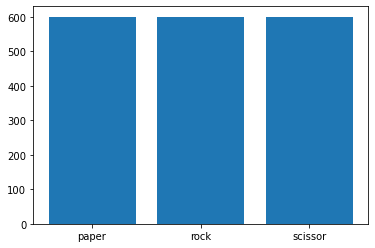

Minimum images per class: 600
Maximum images per class: 600


In [386]:
plt.bar(classes, imgs_per_class)
plt.show()

print('Minimum images per class: ' + str(min(imgs_per_class)))
print('Maximum images per class: ' + str(max(imgs_per_class)))


**Result:** The data is distributed equally, since care has been taken at the time of creation to avoid introducing any imbalance. <br>
For third-party datasets from the Internet, however, this is important to check to ensure that classes are not underrepresented unintentionally.

## How is the images width's and height's?

In [410]:
img_sizes = []

for c in imgs_path:
    for i in c:
        image = Image.open(i)
        w, h = image.size
        img_sizes.append([w,h])

img_sizes = np.array(img_sizes)

In [411]:
print('Minimum width pixels: ' + str(min(img_sizes[:,0])))
print('Minimum height pixels: ' + str(min(img_sizes[:,1])))
print('Maximum width pixels: ' + str(max(img_sizes[:,0])))
print('Maximum height pixels: ' + str(max(img_sizes[:,1])))

Minimum width pixels: 1280
Minimum height pixels: 720
Maximum width pixels: 1280
Maximum height pixels: 720


**Result:** Every image has the same ratio. This is checked to make sure that no errors appeared in the image saving-process. <br>
Pixelsize of 1280x720 is very large for a CNN (takes too much computation power), therefore images should be downsized in the data precrossing-phase.

## How do the images look like?

Let's take a look at 10 random images per class.

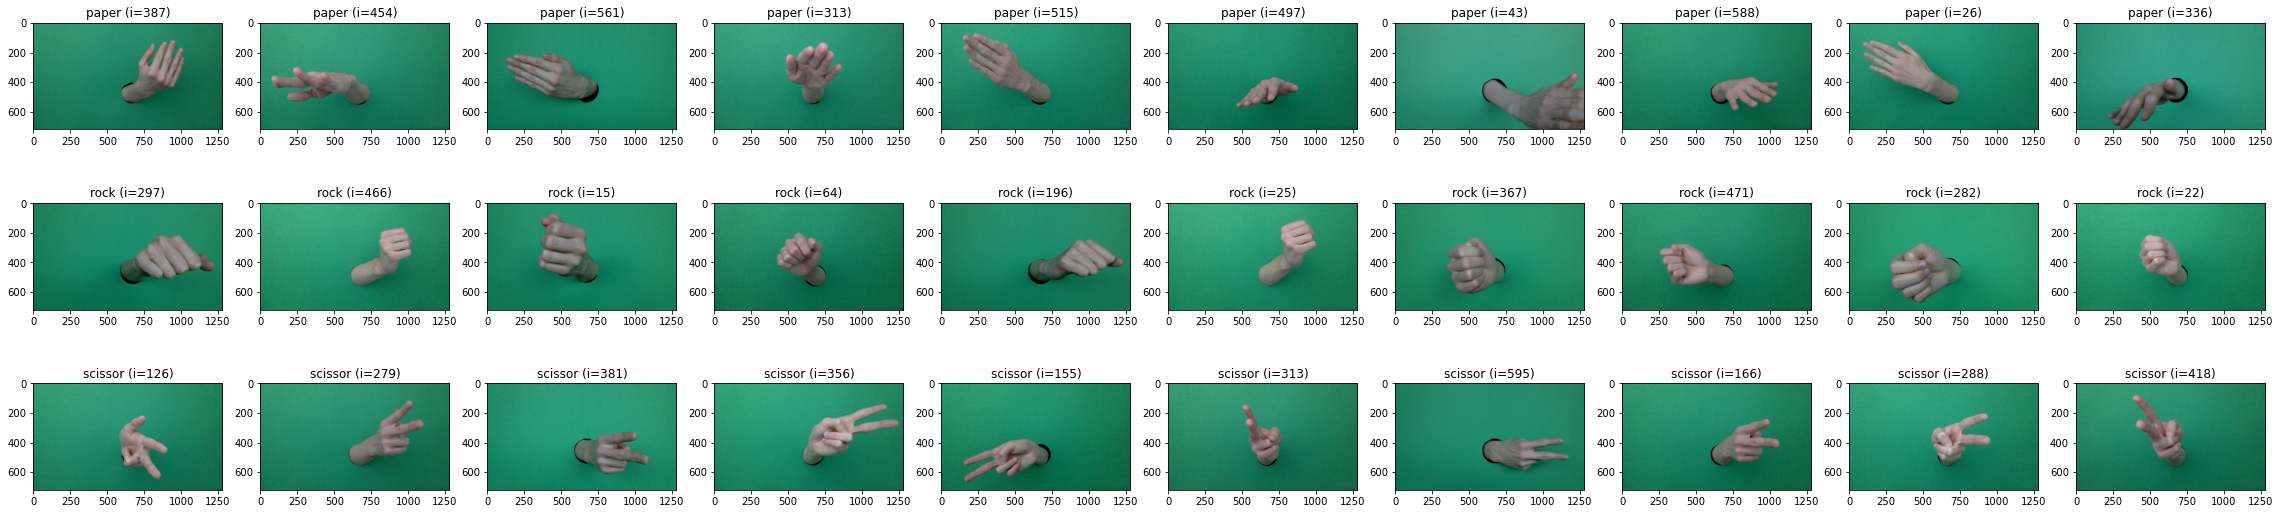

In [380]:
num_classes = len(classes)

plt.figure(figsize=(40,num_classes*3))
ii = 0

for c in range(num_classes):
    for i in range(10):
        ii = ii+1
        o = np.random.randint(0, len(imgs_path[c]))
        
        plt.subplot(3,10,ii)

        img = cv.imread(imgs_path[c][o])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.subplots_adjust(hspace = .4)

        plt.title(classes[c] + ' (i=' + str(o) + ')')


**Result:** <br>
<br>
The images represent the hand gestures "Rock", "Paper" & "Scissors" in different variations: <br>
* Gesture is headed forwards or sideways 
* Hand is facing the camera with either the front or back of the hand
* Some images include the arm, some not
* Gestures do not always look the same: e.g. fingers are spreaded / not spreaded, hand is pressed / hand is loose ...
* Every image is perfectly exposed
* Only two different hands are visible (mine & my girlfriend's)
* The skin color is always white
* Background is always a greenscreen with a hole for the arm to fit through  

The Greenscreen was used, to...
1. Seperate the hand as good as possible to enable the model to focus on the hand
2. Enable the possibility to replace the background with different objects, e.g. faces (shown in the next paraphrase)

However, the greenscreen also introduced some limitations:
* The Hand is equally tall most of the time, since all images were done at a distance of 30cm (camera to hand)
* The Hand, but especially the arm is always centred
* The images include nothing which could distract them (arm, shoulder, body, face, furniture etc)

Some of the limitations can be solved by applaying Image Augmentation, e.g. reducing / enlarging the distance from camera to hand by zooming in & out. <br>
Others, like the limited skin color can **not** be solved with Image Augmentation (pictures can be darkened, but this does not make a white hand black). Only a collection of additional data could help solving this limitation, which have been omitted at this point due to the limited resources.<br>

# Data Preparation

**Data exploration shows:** Thanks to the carefully executed data generation, there is hardly any need to prepare the data for the modeling process.

Limitations that can be resolved by simple Image Augmentation will not be done in this notebook, because it can be done more easily within the modelling notebook.

The only preparation done within this notebook is the train-, test-, validation split. Furthermore, the following section will demonstrate how the greenscreen could be replaced to add more noise to the images.

## Greenscreen replacement

**Important Note:** The purpose of this chapter is solely to show how the green screen could be replaced in theory. However, this step was not applied to the final data set.

This method has not been applied to the final datasat, since live-demo results of the model were satisfactory without this step. Therefore, with respect to the limited time of this project, this step was saved for follow-up projects.

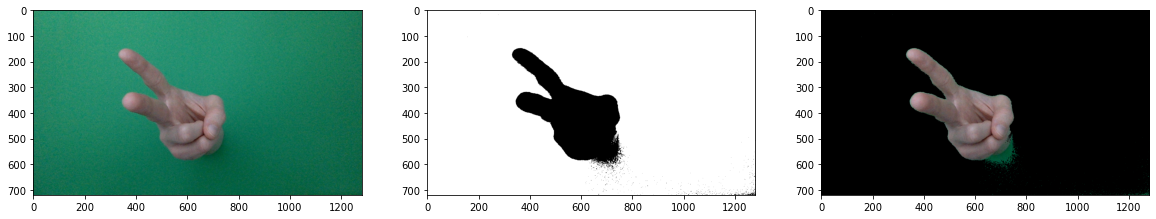

In [399]:
front = cv.imread('data/raw/scissor/scissor_598.jpg')
front = cv.cvtColor(front, cv.COLOR_BGR2RGB)

# Define lower- & upper bounds for R value, G value, B value
lower_green = np.array([0, 90, 0]) 
upper_green = np.array([75, 255, 255]) 

# Create a mask based on lower- & upper bounds
mask = cv.inRange(front, lower_green, upper_green)

# Create image where only masked pixels have a colour
masked_front = np.copy(front)
masked_front[mask != 0] = [0, 0, 0]

# Print results
plt.figure(figsize=(21,4))

plt.subplot(1,3,1)
plt.imshow(front)

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(masked_front)

**Result:** Masking works almost perfectly. However, some green pixels remain green around the hand. These can not be removed, because this would lead to masked spots on the hand.

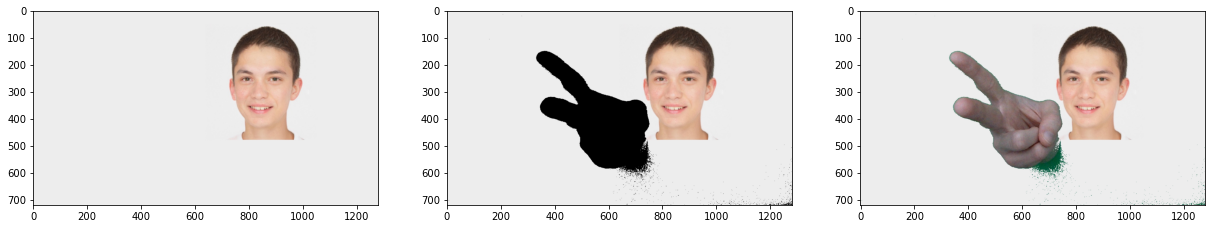

In [406]:
# Load background image, Source: https://www.kaggle.com/tunguz/1-million-fake-faces
back = cv.imread('doc_imgs/gen_face.jpg')
back = cv.cvtColor(back, cv.COLOR_BGR2RGB)

# Create image where only masked pixels have a colour
masked_back = back.copy()
masked_back[mask == 0] = [0, 0, 0]

# Combine both masked images
result = masked_back + masked_front

#Print results
plt.figure(figsize=(21,4))

plt.subplot(1,3,1)
plt.imshow(back)

plt.subplot(1,3,2)
plt.imshow(masked_back)

plt.subplot(1,3,3)
plt.imshow(result)

**Result:** Any distractions, like the head of this kid in this example, can be added behind the masked image afterwards.

## Train-, Test-, Validation Split

Data is split into 60% train, 20% validation and 20% test-Data. 

In [336]:
splitfolders.ratio(input = raw_path, output=split_path, seed=1, ratio=(.6, .2, .2), group_prefix=None) 

Copying files: 1799 files [00:09, 186.70 files/s]


In [337]:
for sd in ['Train', 'Test', 'Val']:
    print ('Distribution in ' + sd + ':')
    for c in classes:
        print (c + ': ' + str(len(os.listdir(split_path + '/' + sd + '/' + c))))

Distribution in Train:
paper: 360
rock: 359
scissor: 360
Distribution in Test:
paper: 120
rock: 121
scissor: 120
Distribution in Val:
paper: 120
rock: 119
scissor: 120


**Result:** Within the splits, all classes continue to be represented in a very balanced way.

##### Next notebook is "modelling.ipynb"